In [1]:
!pip install sentencepiece

In [2]:
!pip install -qqq accelerate peft bitsandbytes transformers trl

In [3]:
import os
import torch
import numpy as np
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer
from transformers import PushToHubCallback
from huggingface_hub import HfFolder
import sys
from huggingface_hub import hf_hub_download
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_score, f1_score, confusion_matrix

# HuggingFace

* Make sure the Token is write token.

* Make sure The repo doesnot exist.

In [4]:
repo_token=""
repo_id=""
HfFolder.save_token(repo_token)

# Model



In [6]:
# The model that you want to train from the Hugging Face hub
model_name = "MohamedAtta-AI/al-baka-llama3-8b-QADI"

# Change the name here
new_model = "al-baka-llama3-8b-QADI"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 4

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./checks"

# Number of training epochs
num_train_epochs = 5

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 6

# Batch size per GPU for evaluation
per_device_eval_batch_size = 6

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 2

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 1e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 100

# Log every X updates steps
logging_steps = 100

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = 285

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = "auto"

In [7]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1


# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
def compute_metrics(p): #p should be of type EvalPrediction
    preds = np.argmax(p.predictions, axis=1)
    assert len(preds) == len(p.label_ids)
    macro_f1 = f1_score(p.label_ids, preds, average='macro')
    macro_recall = recall_score(p.label_ids, preds, average='macro')
    macro_precision = precision_score(p.label_ids, preds, average='macro')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'macro_f1' : macro_f1,
        'accuracy': acc,
        'recall':macro_recall,
        'precision': macro_precision
      }

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
tokenizer.eos_token

'<|end_of_text|>'

In [11]:
main_dir = ''
train = pd.read_csv(main_dir+"train_cleaned.csv", encoding = "utf-8")
test = pd.read_csv(main_dir+"test_cleaned.csv", encoding = "utf-8")

In [12]:
train = train[['text_cleaned', 'label']]
test = test[['text_cleaned', 'label']]

In [13]:
def stratified_sampling(df, sample_size_per_label=5000):
    n_labels = df['label'].nunique()

    # Create a dictionary to store the stratified sample for each label
    stratified_sample = {}

    # Loop through each unique label
    for label in df['label'].unique():
      # Get the data for the current label
      label_data = df[df['label'] == label]

      # Sample rows proportionally from the current label's data
      label_sample = label_data.sample(sample_size_per_label)

      # Add the label sample to the stratified_sample dictionary
      stratified_sample[label] = label_sample

    # Combine all the label samples into a single dataframe
    all_samples = pd.concat(stratified_sample.values())
    return all_samples

In [14]:
train = stratified_sampling(train)

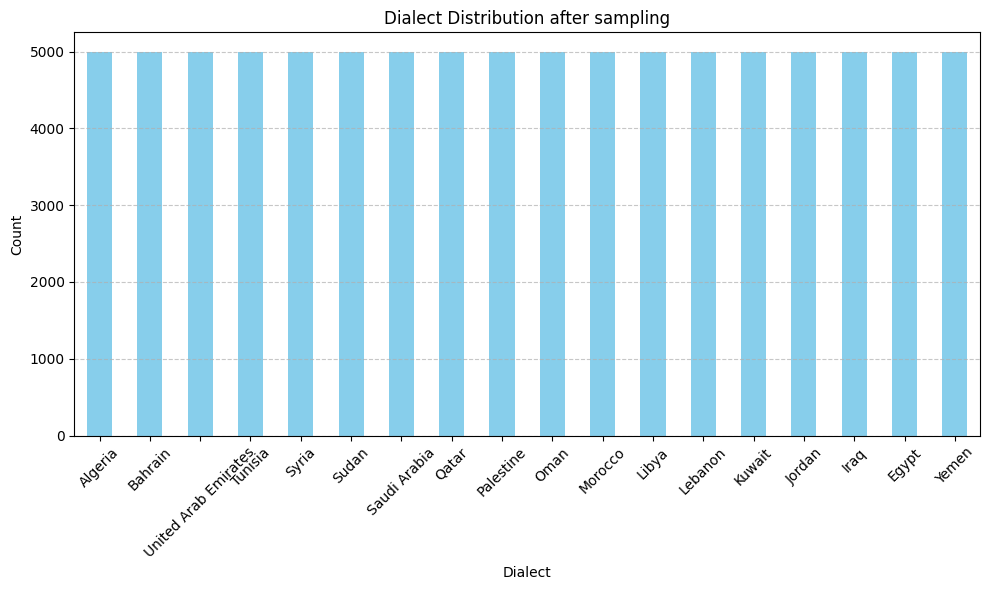

In [15]:
import matplotlib.pyplot as plt
dialect_counts = train['label'].value_counts()

plt.figure(figsize=(10, 6))
dialect_counts.plot(kind='bar', color='skyblue')
plt.title('Dialect Distribution after sampling')
plt.xlabel('Dialect')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
# Create splits
train, val = train_test_split(train, test_size=0.2, random_state=1, shuffle=True)

In [17]:
def create_template(df):
  for index, row in df.iterrows():
      instruction = row["text_cleaned"]
      try:
        Response = row["label"]
      except:
        Response = ''

      template = """
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an Arabic dialect identifier.<|eot_id|><|start_header_id|>user<|end_header_id|>

{instruction}<|eot_id|><|start_header_id|>AI<|end_header_id|>

{Response}<|eot_id|><|end_of_text|>
""".strip()

      prompt = template.format(instruction=instruction, Response=Response)

      df['text_cleaned'].at[index] = prompt

In [18]:
train.head()

,text_cleaned,label
18318,ياهلا باغلي الحبايب ياهلا بريحه هلي بدرك عني غ...,Bahrain
90246,عامر والشحات يقدموا مستوي سيء وبالرغم نشوفهم ا...,Oman
5706,سنه وانت بالف الف خير ربي يديم نعمه الصحه والس...,Algeria
47311,متابع التايم لاين فهو نزل تغريده يرد عليكي بدي...,Jordan
30444,تخيلوا وياي اميركا او بريطانيا حاربوا داعش ارا...,Iraq


In [19]:
create_template(train)
create_template(val)
create_template(test)

In [20]:
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)

In [21]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard",
    push_to_hub=True,
    hub_model_id=repo_id,
    hub_strategy="every_save",
    hub_token=repo_token,
)

In [22]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    peft_config=peft_config,
    dataset_text_field="text_cleaned",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
    compute_metrics=compute_metrics
)

Map:   0%|          | 0/72000 [00:00<?, ? examples/s]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

In [23]:
trainer.train()

Step,Training Loss
100,4.348000
200,3.858500
300,3.765200
400,3.708100
500,3.691100
600,3.654800
700,3.637000
800,3.643900
900,3.626200
1000,3.617200


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/

In [ ]:
trainer.model.save_pretrained(new_model)